In [31]:
import cv2
import numpy as np
import time
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Import your modules:
from detectors.facial_landmarks_processor import FacialLandmarksProcessor
from utils.shared_variables import SharedVariables
from utils.vtube_mapper import map_metrics_to_vts_params
from filter.kalman_filter import KalmanFilter
from utils.calculations import fps_calculation

# Import the emotion recognition function from your file.
from emotion_recognition import recognize_emotion

# Configure logging.
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)


In [ ]:
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise Exception("Unable to open video device")

cap.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)

# Initialize the detector.
processor = FacialLandmarksProcessor()

# Evaluation counters and metric lists.
frame_count = 0
detected_face_count = 0
latency_list = []

# Continuous metrics storage.
mar_predictions = []      # Predicted MAR values
mar_groundtruths = []     # Simulated ground truth MAR (e.g. 0.2)
ear_left_list = []
ear_right_list = []
lip_sync_list = []
head_pose_list = []       # (yaw, pitch, roll)

# Emotion recognition evaluation.
emotion_predictions = []
emotion_groundtruths = []
emotion_correct = 0
emotion_expected = "neutral"  # Change if needed

# Process emotion less frequently.
emotion_interval = 5
current_emotion = "unknown"

print("Starting improved realtime feed. Press 'q' to quit.")

while True:
    start_time = time.time()
    ret, frame = cap.read()
    if not ret:
        logger.error("Failed to grab frame from camera.")
        continue

    # Process the frame using your facial detector pipeline.
    metrics = processor.process_frame(frame)
    
    if metrics:
        detected_face_count += 1
        
        ear_left = metrics.get("ear_left", np.nan)
        ear_right = metrics.get("ear_right", np.nan)
        mar = metrics.get("mar", np.nan)
        lip_sync_val = metrics.get("lip_sync_value", np.nan)
        head_pose = metrics.get("head_pose", {})
        if head_pose and head_pose.get("rotation_vector") is not None:
            rot_vec = head_pose.get("rotation_vector")
            try:
                yaw = float(rot_vec[0])
                pitch = float(rot_vec[1])
                roll = float(rot_vec[2])
            except Exception:
                yaw, pitch, roll = np.nan, np.nan, np.nan
        else:
            yaw, pitch, roll = np.nan, np.nan, np.nan
        
        ear_left_list.append(ear_left)
        ear_right_list.append(ear_right)
        mar_predictions.append(mar)
        mar_groundtruths.append(0.2)  # Simulated ground truth value
        lip_sync_list.append(lip_sync_val)
        head_pose_list.append((yaw, pitch, roll))
        
        # Run emotion recognition every `emotion_interval` frames.
        if frame_count % emotion_interval == 0:
            current_emotion = recognize_emotion(frame)
        emotion_predictions.append(current_emotion)
        emotion_groundtruths.append(emotion_expected)
        if current_emotion.lower() == emotion_expected.lower():
            emotion_correct += 1

        overlay_text1 = f"MAR: {mar:.3f} | EAR L: {ear_left:.3f} | EAR R: {ear_right:.3f}"
        overlay_text2 = f"Emotion: {current_emotion} | LipSync: {lip_sync_val:.3f}"
        overlay_text3 = f"Head Pose: ({yaw:.2f}, {pitch:.2f}, {roll:.2f})"
        cv2.putText(frame, overlay_text1, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
        cv2.putText(frame, overlay_text2, (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,0), 1)
        cv2.putText(frame, overlay_text3, (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1)
    else:
        cv2.putText(frame, "No face detected", (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,0,255), 1)
        ear_left_list.append(np.nan)
        ear_right_list.append(np.nan)
        mar_predictions.append(np.nan)
        mar_groundtruths.append(0.2)
        lip_sync_list.append(np.nan)
        head_pose_list.append((np.nan, np.nan, np.nan))
        emotion_predictions.append("unknown")
        emotion_groundtruths.append(emotion_expected)
    
    elapsed = time.time() - start_time
    latency_list.append(elapsed)
    frame_count += 1

    cv2.imshow("Improved Realtime Feed", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()



In [26]:
avg_latency = np.mean(latency_list)
total_time = np.sum(latency_list)
fps = frame_count / total_time if total_time > 0 else 0
face_detection_accuracy = (detected_face_count / frame_count) * 100

# Compute MSE for MAR (ignoring NaN values)
mar_pred_arr = np.array(mar_predictions)
mar_gt_arr = np.array(mar_groundtruths)
valid_mask = ~np.isnan(mar_pred_arr)
mse_mar = np.mean((mar_pred_arr[valid_mask] - mar_gt_arr[valid_mask])**2) if np.sum(valid_mask) > 0 else np.nan

emotion_accuracy = (emotion_correct / frame_count) * 100

print(f"Total frames processed: {frame_count}")
print(f"Face Detection Accuracy: {face_detection_accuracy:.2f}%")
print(f"Average Latency per Frame: {avg_latency * 1000:.2f} ms")
print(f"Approximate FPS: {fps:.2f}")
print(f"MSE for MAR: {mse_mar:.4f}")
print(f"Emotion Recognition Accuracy (expected '{emotion_expected}'): {emotion_accuracy:.2f}%")


Total frames processed: 320
Face Detection Accuracy: 100.00%
Average Latency per Frame: 39.36 ms
Approximate FPS: 25.41
MSE for MAR: 0.0715
Emotion Recognition Accuracy (expected 'neutral'): 37.50%


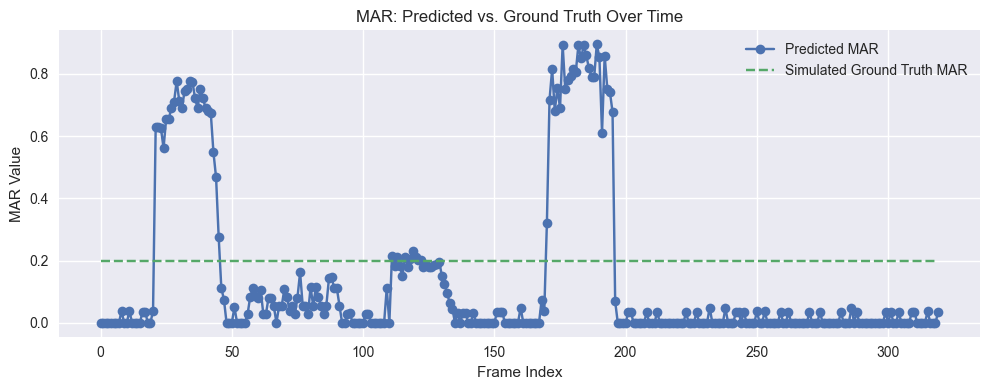

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

# Ensure our figures appear clearly.
plt.style.use("seaborn-v0_8")

# 1. MAR Predictions vs. Ground Truth Over Time
plt.figure(figsize=(10, 4))
frames = np.arange(len(mar_predictions))
plt.plot(frames, mar_predictions, label="Predicted MAR", marker="o")
plt.plot(frames, mar_groundtruths, label="Simulated Ground Truth MAR", linestyle="--")
plt.xlabel("Frame Index")
plt.ylabel("MAR Value")
plt.title("MAR: Predicted vs. Ground Truth Over Time")
plt.legend()
plt.tight_layout()
plt.show()



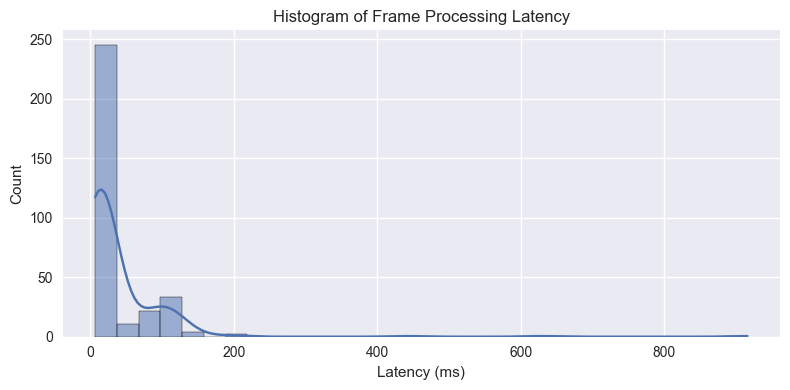

In [28]:
# 2. Histogram of Frame Processing Latency
# Convert latency from seconds to milliseconds.
latency_ms = [lat * 1000 for lat in latency_list]
plt.figure(figsize=(8, 4))
sns.histplot(latency_ms, kde=True, bins=30)
plt.xlabel("Latency (ms)")
plt.title("Histogram of Frame Processing Latency")
plt.tight_layout()
plt.show()


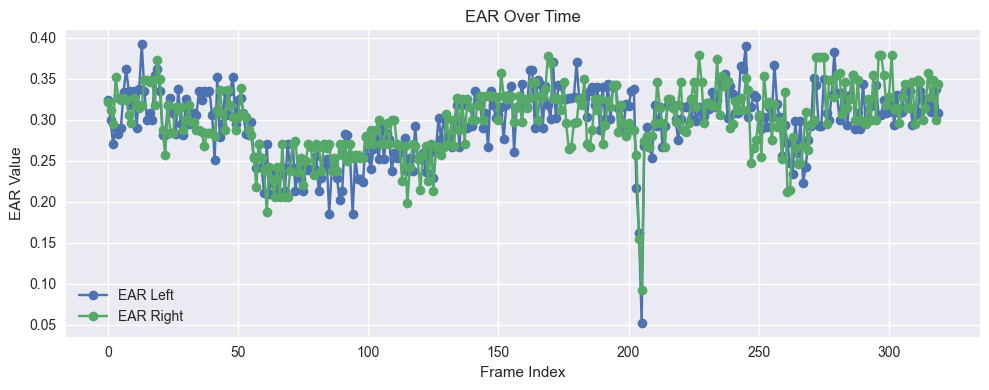

In [29]:
# 3. EAR (Left and Right) Over Time
plt.figure(figsize=(10, 4))
plt.plot(np.arange(len(ear_left_list)), ear_left_list, label="EAR Left", marker="o")
plt.plot(np.arange(len(ear_right_list)), ear_right_list, label="EAR Right", marker="o")
plt.xlabel("Frame Index")
plt.ylabel("EAR Value")
plt.title("EAR Over Time")
plt.legend()
plt.tight_layout()
plt.show()


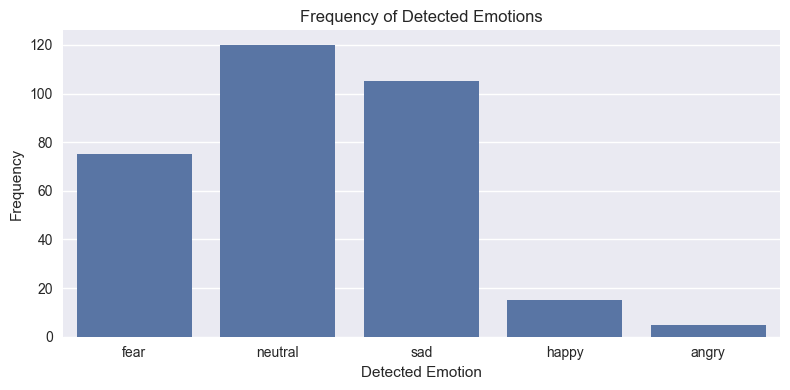

In [30]:
# 4. Emotion Recognition Frequency
emotion_counts = Counter(emotion_predictions)
plt.figure(figsize=(8, 4))
sns.barplot(x=list(emotion_counts.keys()), y=list(emotion_counts.values()))
plt.xlabel("Detected Emotion")
plt.ylabel("Frequency")
plt.title("Frequency of Detected Emotions")
plt.tight_layout()
plt.show()
